In [135]:
import warnings
import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scipy.misc import imsave
import matplotlib.pyplot as plt

In [136]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [137]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))

In [138]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [147]:
m = 250 # batch size
n_z = 30 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 50

In [148]:
X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

In [149]:
inputs = concat([X, label])


In [150]:
encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

In [151]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

In [152]:
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

In [153]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [156]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [155]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [157]:
def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [158]:
cvae = Model([X, label], outputs)
encoder = Model([X, label], mu)

d_in = Input(shape=(n_z+n_y,))
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)

In [159]:
cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss])

In [160]:
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=10,
validation_data = ([X_test, y_test], X_test),
callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 13s 209us/step - loss: 180.3070 - KL_loss: 16.8125 - recon_loss: 163.4945 - val_loss: 136.0896 - val_KL_loss: 21.4821 - val_recon_loss: 114.6075
Epoch 2/10
60000/60000 [==============================] - 15s 252us/step - loss: 127.8365 - KL_loss: 22.3692 - recon_loss: 105.4674 - val_loss: 120.0249 - val_KL_loss: 23.0536 - val_recon_loss: 96.9713
Epoch 3/10
60000/60000 [==============================] - 13s 222us/step - loss: 117.6408 - KL_loss: 23.6911 - recon_loss: 93.9497 - val_loss: 113.4961 - val_KL_loss: 24.1304 - val_recon_loss: 89.3658
Epoch 4/10
60000/60000 [==============================] - 12s 195us/step - loss: 112.9622 - KL_loss: 24.1051 - recon_loss: 88.8571 - val_loss: 110.2798 - val_KL_loss: 24.2408 - val_recon_loss: 86.0390
Epoch 5/10
60000/60000 [==============================] - 12s 194us/step - loss: 110.2083 - KL_loss: 24.2052 - recon_loss: 86.0032 - val_loss: 

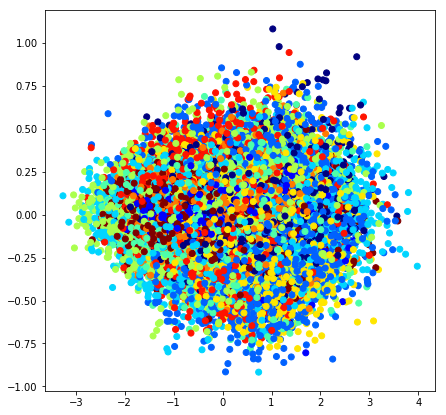

In [161]:
z_train = encoder.predict([X_train, y_train])
encodings= np.asarray(z_train)
encodings = encodings.reshape(X_train.shape[0], n_z)
plt.figure(figsize=(7, 7))
plt.scatter(encodings[:, 0], encodings[:, 1], c=Y_train, cmap=plt.cm.jet)
plt.show()

In [162]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

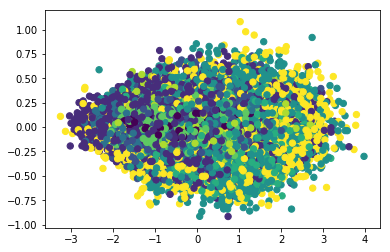

In [163]:
gmm = GMM(n_components=9).fit(encodings)

labels = gmm.predict(encodings)
plt.scatter(encodings[:, 0], encodings[:, 1], c=labels, s=40, cmap='viridis');

#Pick elements corresponding to n-th label
n= 4

subset = []
for i in range(0,labels.size):
    if labels[i]==n:
        subset.append((encodings[i]))
    else:
        pass
subset = np.array(subset)

In [164]:
def construct_numvec(z):
    out = np.zeros((1, n_z + n_y))
    for i in range(len(z)):
        out[:,i] = z[i]
    return(out)
    


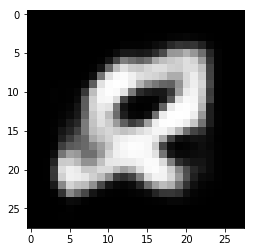

In [167]:
#Change 
plt.imshow((decoder.predict(construct_numvec(subset[4000]))).reshape(28,28), cmap = plt.cm.gray)
plt.show()

In [119]:
subset[6]

array([-3.256847 , -1.1342045], dtype=float32)